In [159]:
%load_ext autoreload
%autoreload 2

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

from vehicle_eco_balance import Consumption, Car
from vehicle_eco_balance import get_interval_time, calc_acceleration, calc_distance, calc_gradient_angle, calc_efficiency

import numpy as np
from matplotlib import pyplot as plt

config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
# 52b495a7e4b0f9afbd2e7fc6 (from paper)
# 5f17fa6dd2ad470001e79748 (electric)

track_df = track_api.get_track('52b495a7e4b0f9afbd2e7fc6')

track_df.head()

,id,time,geometry,GPS Bearing.value,GPS Bearing.unit,GPS PDOP.value,GPS PDOP.unit,GPS VDOP.value,GPS VDOP.unit,GPS Accuracy.value,...,track.begin,track.end,track.touVersion,sensor.type,sensor.engineDisplacement,sensor.model,sensor.id,sensor.fuelType,sensor.constructionYear,sensor.manufacturer
0,52b495a7e4b0f9afbd2e7fc8,2013-12-20T16:24:35,POINT (7.60028 51.97748),13.570000,deg,1.3,precision,1.1,precision,5.0,...,2013-12-20T16:24:35Z,2013-12-20T17:38:02Z,2013-10-01,car,1149,Clio,525e30a9e4b000fe057e6c86,gasoline,2003,Renault
1,52b495a7e4b0f9afbd2e7fca,2013-12-20T16:24:41,POINT (7.60028 51.97748),13.570000,deg,1.3,precision,1.1,precision,5.0,...,2013-12-20T16:24:35Z,2013-12-20T17:38:02Z,2013-10-01,car,1149,Clio,525e30a9e4b000fe057e6c86,gasoline,2003,Renault
2,52b495a8e4b0f9afbd2e7fcc,2013-12-20T16:24:47,POINT (7.60024 51.97752),319.600006,deg,1.2,precision,1.0,precision,5.0,...,2013-12-20T16:24:35Z,2013-12-20T17:38:02Z,2013-10-01,car,1149,Clio,525e30a9e4b000fe057e6c86,gasoline,2003,Renault
3,52b495a8e4b0f9afbd2e7fce,2013-12-20T16:24:53,POINT (7.60007 51.97761),315.209991,deg,1.2,precision,1.0,precision,5.0,...,2013-12-20T16:24:35Z,2013-12-20T17:38:02Z,2013-10-01,car,1149,Clio,525e30a9e4b000fe057e6c86,gasoline,2003,Renault
4,52b495a8e4b0f9afbd2e7fd0,2013-12-20T16:24:59,POINT (7.59981 51.97773),267.910004,deg,1.2,precision,1.0,precision,5.0,...,2013-12-20T16:24:35Z,2013-12-20T17:38:02Z,2013-10-01,car,1149,Clio,525e30a9e4b000fe057e6c86,gasoline,2003,Renault


In [162]:
dt = np.zeros(len(track_df['time']))

for i in range(1, len(track_df['time'])):
    dt[i] = get_interval_time(track_df['time'][i],track_df['time'][i-1])

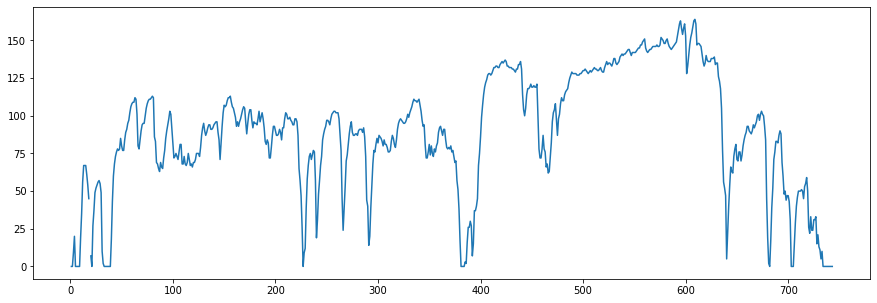

In [191]:
speed = np.array(track_df['Speed.value'])
plt.figure(figsize=(15,5))
plt.plot(speed);

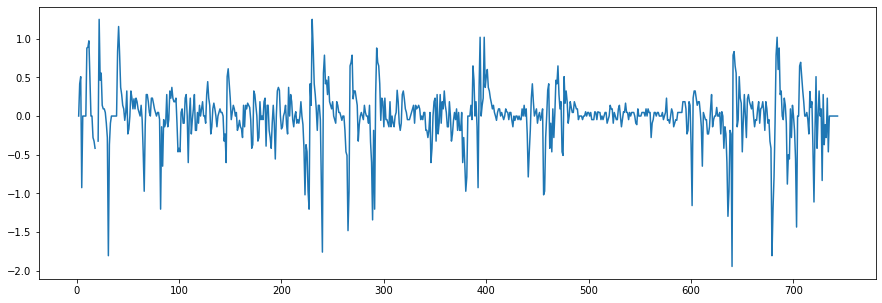

In [190]:
acceleration = calc_acceleration(speed, dt)
plt.figure(figsize=(15,5))
plt.plot(acceleration);

In [178]:
altitudes = np.array(track_df['GPS Altitude.value'])
geom = np.array(track_df['geometry'])

lngs = list(track_df['geometry'].x)
lats = list(track_df['geometry'].y)
points = [point for point in zip(lats, lngs, altitudes)]

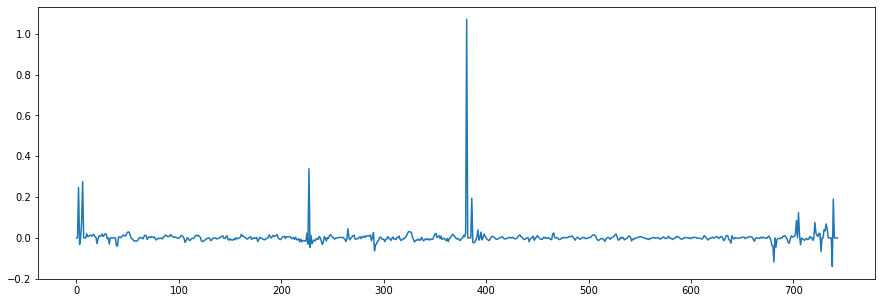

In [189]:
gradient_angle = np.zeros(len(points))

for i in range(1, len(points)):
    gradient_angle[i] = calc_gradient_angle(points[i-1],points[i])

plt.figure(figsize=(15,5))
plt.plot(gradient_angle);

In [184]:
cons = Consumption()

car = Car()

consumption_gps = cons.calculate_consumption(speed, acceleration, gradient_angle, car, 0.02)
consumption_gps

array([        nan,         nan,  0.56818182,  0.80336297,  1.94634983,
        0.89251927,  0.56818182,  0.83533884,  0.83533884,  0.83533884,
        2.918115  ,  5.06941382,  8.75452388,  8.14035018,  4.44404035,
        3.91565709,  1.34860299,  0.89779797,  0.96573441,         nan,
               nan,  0.98733458,  4.97767771,  3.96718885,  5.90637025,
        4.48054416,  3.52176267,  4.18929738,  4.4109037 ,  3.03806676,
        0.94174752,  2.27272727,  1.15557072,  0.86859415,  0.83533884,
        0.83533884,  0.83533884,  0.83533884,  0.83533884,  0.98752147,
        1.69276303,  7.19690391,  8.35560249,  6.5595758 ,  6.7799852 ,
        6.26973094,  6.45858041,  4.31189648,  5.60332541,  9.93603194,
        4.6738416 ,  5.22287871,  5.96764809,  8.20994077,  7.33889154,
        5.49644886,  6.57086275,  5.21218395,  7.33660551,  7.43071054,
        6.85990504,  7.67636483,  7.54959898,  9.51641406,  6.87406641,
        0.96362827,  1.2341697 ,  4.178188  ,  8.61985584,  7.47

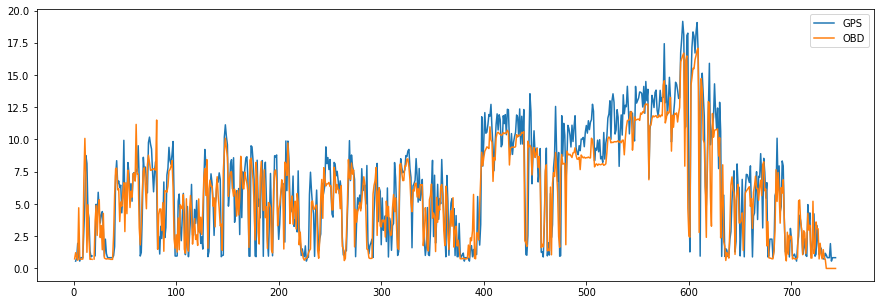

In [185]:
consumption_obd = track_df['Consumption.value']

plt.figure(figsize=(15,5))
plt.plot(consumption_gps, label="GPS");
plt.plot(consumption_obd, label="OBD");
plt.legend();

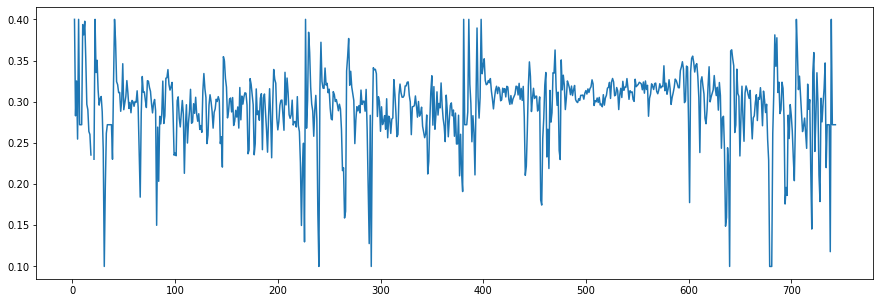

In [187]:
plt.figure(figsize=(15,5))
plt.plot(cons.efficiency);